In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from os import listdir
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import random

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

def draw_prediction(prediction):
    prediction[prediction < 0.5] = 0
    prediction[prediction >= 0.5] = 1
    reshaped = prediction.reshape(553,534)
    original_sized = np.zeros((584, 565))
    original_sized[15:568, 15:549] = reshaped
    plt.imshow(original_sized, cmap='gray')

def extract_patches(img, patch_size):
    assert(patch_size % 2 == 1)
    patches = []
    for i in range(0, img.shape[0] - patch_size):
        for j in range(0, img.shape[1] - patch_size):
            patches.append(img[i:i + patch_size,j:j+patch_size])
    return patches

def prepare_img(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hist_eq = clahe.apply(gray)
    gamma = 1.2
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected = cv2.LUT(hist_eq, table)
    return gamma_corrected

def prepare_labels(labeled_img, path_size):
    labeled_extracted = extract_patches(labeled_img, path_size)
    y_train = []
    for i in labeled_extracted:
        y_train.append((int)(i[15,15] / 255))
    return y_train

def extract_patches_and_labels(imgs_dir_path, labeled_imgs_dir_path):
    imgs_paths = listdir(imgs_dir_path)
    labeled_imgs_paths = listdir(labeled_imgs_dir_path)

    #modification due to memory constraints:
    imgs_paths = [imgs_paths[0]]
    labeled_imgs_paths = [labeled_imgs_paths[0]]
    
    all_patches = []
    all_labels = []
    for img_path, labeled_img_path in zip(imgs_paths, labeled_imgs_paths):
        img = cv2.imread(imgs_dir_path + img_path)
        labeled = plt.imread(labeled_imgs_dir_path + labeled_img_path)

        gamma_corrected = prepare_img(img)
        patches = extract_patches(gamma_corrected, 31)
        labels = prepare_labels(labeled, 31)

        all_patches = all_patches + patches
        all_labels = all_labels + labels
    return all_patches, all_labels

In [3]:
imgs_dir_path = 'data/DRIVE/training/images/'
labeled_imgs_dir_path = 'data/DRIVE/training/1st_manual/'

all_patches, all_labels = extract_patches_and_labels(imgs_dir_path, labeled_imgs_dir_path)

24658


In [12]:
#undersampling

minority_examples_number = sum(all_labels)

labelToPatches = {
    0:[],
    1:[]
}

for patch, label in zip(all_patches, all_labels):
    labelToPatches[label].append(patch)

In [19]:
minority_examples = labelToPatches[1]
majority_examples = labelToPatches[0]
majority_undersampled = random.sample(majority_examples, len(minority_examples))

len(minority_examples) == len(majority_undersampled)

True

In [25]:
def shuffle(minority_examples, majority_examples):
    all_examples = minority_examples + majority_examples
    labels = [1] * len(minority_examples) + [0] * len(majority_examples)
    
    combined = list(zip(all_examples, labels))
    random.shuffle(combined)

    all_examples[:], labels[:] = zip(*combined)
    return all_examples, labels

shuffled, labels = shuffle(minority_examples, majority_undersampled)

1

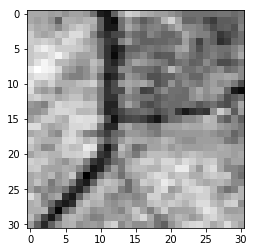

In [31]:
plt.imshow(shuffled[2], cmap='gray')
labels[2]

In [39]:
X_train = np.asarray(shuffled) / 255
y_train = np.asarray(labels)

49316

In [35]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(31,31,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
X_train = X_train.reshape(X_train.shape[0],31,31,1)

In [49]:
model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=5)

Train on 49316 samples, validate on 49316 samples
Epoch 1/5
49316/49316 [==============================] - 74s 1ms/step - loss: 0.2557 - acc: 0.8949 - val_loss: 0.2294 - val_acc: 0.9112
Epoch 2/5
49316/49316 [==============================] - 102s 2ms/step - loss: 0.2126 - acc: 0.9159 - val_loss: 0.1921 - val_acc: 0.9274
Epoch 3/5
49316/49316 [==============================] - 103s 2ms/step - loss: 0.1960 - acc: 0.9237 - val_loss: 0.1865 - val_acc: 0.9276
Epoch 4/5
49316/49316 [==============================] - 102s 2ms/step - loss: 0.1872 - acc: 0.9275 - val_loss: 0.1817 - val_acc: 0.9287
Epoch 5/5
49316/49316 [==============================] - 102s 2ms/step - loss: 0.1790 - acc: 0.9302 - val_loss: 0.1987 - val_acc: 0.9214


In [42]:
model.save_weights('simple.h5')

In [44]:
def prepare_test_patches(img_path):
    img = cv2.imread(img_path)
    prepared = prepare_img(img)
    patches = extract_patches(prepared, 31)
    normalized = np.asarray(patches)/255
    return normalized.reshape(normalized.shape[0],31,31,1)

In [45]:
X_test = prepare_test_patches('data/DRIVE/training/images/21_training.tif')

In [50]:
prediction = model.predict(X_test)

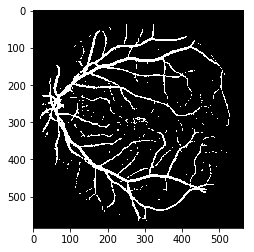

In [51]:
draw_prediction(prediction)